In [1]:
import pyomo.environ as oe
import pandas as pd
from pyomo.opt import SolverFactory
from subproblem_model import build_subproblem_model
from subproblem_dataloader import DataLoader

## Load data for each set, parameter, etc. to define a problem instance

In [2]:
data = DataLoader()

In [3]:
#display(data.BMPGRPING)
#display(data.BMPGRPING)

## Create concrete problem instance using the separately defined optimization model

In [4]:
# Note that there is no need to call create_instance on a ConcreteModel
mdl = build_subproblem_model(pltnts=data.PLTNTS,
                             lrsegs=data.LRSEGS,
                             bmps=data.BMPS,
                             bmpgrps=data.BMPGRPS,
                             bmpgrping=data.BMPGRPING,
                             loadsrcs=data.LOADSRCS,
                             bmpsrclinks=data.BMPSRCLINKS,
                             bmpgrpsrclinks=data.BMPGRPSRCLINKS,
                             c=data.c,
                             e=data.E,
                             tau=data.tau,
                             phi=data.phi,
                             t=data.T)

In [5]:
# Print the target load reduction values
for l in mdl.LRSEGS:
    for p in mdl.PLTNTS:
        print('%s: %d' % (mdl.tau[l,p], mdl.tau[l,p].value))

tau[N51133RL0_6450_0000,S]: 7
tau[N51133RL0_6450_0000,P]: 7
tau[N51133RL0_6450_0000,N]: 7


## Solve problem instance

In [6]:
solver = SolverFactory("minos")
results = solver.solve(mdl, tee=True, symbolic_solver_labels=True, keepfiles=True)

print('\nObjective is:')
print(mdl.Total_Cost())
# print(results)

Solver log file: '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpw_g8dzpp_minos.log'
Solver solution file: '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpgfk1qlxx.pyomo.sol'
Solver problem files: ('/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpgfk1qlxx.pyomo.nl',)
MINOS 5.51Objective is:
842698.0544321463


## Examine results

In [7]:
for l in mdl.LRSEGS:
    for p in mdl.PLTNTS:
        print('%s: %d' % (mdl.TargetPercentReduction[l,p], oe.value(mdl.TargetPercentReduction[l,p].body)))

TargetPercentReduction[N51133RL0_6450_0000,S]: 45
TargetPercentReduction[N51133RL0_6450_0000,P]: 7
TargetPercentReduction[N51133RL0_6450_0000,N]: 7


In [8]:
# Extract just the nonzero optimal variable values
tol = 1e-6
nzvarnames = []
nzvarvalus = []
for k in mdl.x.keys():
    if (not not mdl.x[k].value):
        if abs(mdl.x[k].value)>tol:
            nzvarnames.append(mdl.x[k].getname())
            nzvarvalus.append(mdl.x[k].value)
            
# Repeat the same thing, but make a DataFrame
nonzerokeyvals_df = pd.DataFrame([[k, mdl.x[k].value]
                                  for k in mdl.x.keys()
                                  if (not not mdl.x[k].value) 
                                  if abs(mdl.x[k].value)>tol],
                                 columns=['key', 'value'])
# display(nonzerokeyvals_df.head(2))

nonzerodf = pd.DataFrame.from_dict([{'bmpshortname':x[0],
                                     'landriversegment':x[1],
                                     'loadsource': x[2],
                                     'acres': y}
                                    for x, y in zip(nonzerokeyvals_df.key, nonzerokeyvals_df.value)])
# display(nonzerodf.head(2))

In [9]:
# # Other ways to access the optimal values:
# mdl.x['HRTill', 'N51133RL0_6450_0000', 'oac'].value
#
# tol = 1e-6
# for b in mdl.BMPS:
#     for lmbda in mdl.LOADSRCS:
#         bval = mdl.x[b, 'N51133RL0_6450_0000', lmbda].value
#         if not not bval:
#             if abs(bval)>tol:
#                 print('(%s, %s): %d' % (b, lmbda, bval))

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
# from matplotlib import pyplot as plt
# # barh(range(len(res)),res.values(), align='center')
# fig = plt.figure(figsize=(10, 4))
# rects = plt.barh(y=nzvarnames, width=nzvarvalus)
# ax = plt.gca()
# # ax.tick_params(axis='x', colors='white')

In [12]:
# add cost/unit data to results table
costsubtbl = data.costsubtbl
# Retain only those costs pertaining to bmps in our set
includecols = ['totalannualizedcostperunit', 'bmpshortname']
nonzerodf = nonzerodf.merge(costsubtbl.loc[:,includecols])
display(nonzerodf.head(2))

# Add total cost of each BMP to results table for this instance
nonzerodf['totalinstancecost'] = np.multiply(nonzerodf['totalannualizedcostperunit'].values,
                                             nonzerodf['acres'].values)
display(nonzerodf.head(2))
coststrs = [str(x) for x in zip(list(nonzerodf['totalannualizedcostperunit']),
                                list(nonzerodf['totalinstancecost']))]
# display(coststrs)

,acres,bmpshortname,landriversegment,loadsource,totalannualizedcostperunit
0,782.258737,CoverCropTradRED,N51133RL0_6450_0000,gom,68.94
1,3524.195312,IncorpLowEarly,N51133RL0_6450_0000,dbl,17.34


,acres,bmpshortname,landriversegment,loadsource,totalannualizedcostperunit,totalinstancecost
0,782.258737,CoverCropTradRED,N51133RL0_6450_0000,gom,68.94,53928.917314
1,3524.195312,IncorpLowEarly,N51133RL0_6450_0000,dbl,17.34,61109.546719


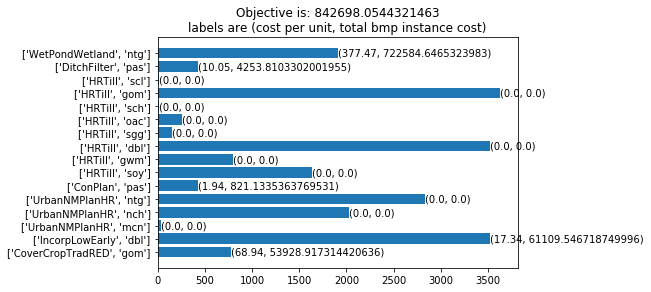

In [13]:
from datetime import datetime
keystrs = [str([x, y]) for x, y in zip(nonzerodf['bmpshortname'], nonzerodf['loadsource'])]

# Make Figure
fig = plt.figure(figsize=(10, 4))
rects = plt.barh(y=keystrs, width=nonzerodf['acres'])
ax = plt.gca()

for rect, label in zip(rects, coststrs):
    width = rect.get_width()
    plt.text(width + 0.1, rect.get_y() + rect.get_height() / 2, label,
            ha='left', va='center')

objstr = ''.join(['Objective is: ', str(mdl.Total_Cost())])
labelstr = 'labels are (cost per unit, total bmp instance cost)'
plt.title('\n'.join([objstr, labelstr]))

ax.set_position([0.3,0.1,0.5,0.8])
#plt.tight_layout()


#plt.savefig(os.path.join(projectpath,''.join(['output/tau19N19P19S_minos_', datetime.now().strftime('%Y-%m-%d_%H%M%S'),'.png'])))

In [25]:
#gjh
opt2 = SolverFactory('gjh')
r2 = opt2.solve(mdl, keepfiles=True)

Solver log file: '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmps1mqcs_p_gjh.log'
Solver solution file: '/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpdrycz4qy.pyomo.sol'
Solver problem files: ('/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpdrycz4qy.pyomo.nl',)


In [16]:
#Read number of variables and constraints
nl_file = open('tmpgfk1qlxx.pyomo.nl','r')
nl_lines = nl_file.readlines()
num_variables = int(nl_lines[1].split(' ')[1])
num_constraints = int(nl_lines[1].split(' ')[2])

In [26]:
print(r2)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
Solver: 
- Status: ok
  Message: gjh\x3a "/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpdrycz4qy.pyomo.gjh" written.  Execute;  ; 	include "/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpdrycz4qy.pyomo.gjh"; 	remove "/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/tmpdrycz4qy.pyomo.gjh";
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.033020734786987305
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [23]:
#Read gjh output file
gjh = oe.AbstractModel()
gjh.n_var = oe.Set(initialize=range(1,num_variables+1))
gjh.n_cons = oe.Set(initialize=range(1,num_constraints+1))
gjh.g = oe.Param(gjh.n_var, default=0)
gjh.J = oe.Param(gjh.n_cons, gjh.n_var, default=0)
gjh.H = oe.Param(gjh.n_var, gjh.n_var, default=0)
gjh_ins = gjh.create_instance('gjh_output.dat')

#Print
for i in gjh_ins.n_var:
    print(gjh_ins.g[i])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
